# Vehicle Detection and Tracking
---

## 1. Writeup / README

#### CRITERIA
- Provide a Writeup / README that includes all the rubric points and how you addressed each one.

The files are submitted in the directory containing this write-up.
The files are
* `CarND-Vehicle-Detection.ipynb` : a jupyter notebook which contains all the required codes.
* `CarND-Vehicle-Detection.html` : a html file exported by the jupyter notebook containing all the execution results.
* `./writeup_images/*` : all the images and video showing the result
* `writeup_vehicle_detection.md` : this write-up file

## 2. Histogram of Oriented Gradients (HOG)

#### CRITERIA
- Explain how (and identify where in your code) you extracted HOG features from the training images. Explain how you settled on your final choice of HOG parameters.


I start by examine the training dataset in the png format provided for this project [vehicle](https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/vehicles.zip) and [non-vehicle images](https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/non-vehicles.zip)

##### DATA EXPLORATION
The number of vehicle images is 8792 and that of non-vehicle images is 8968 which are well balanced. Some image samples are shown below.

A count of 8792  cars and 8968  non-cars of size:  (64, 64, 3)  and data type: float32


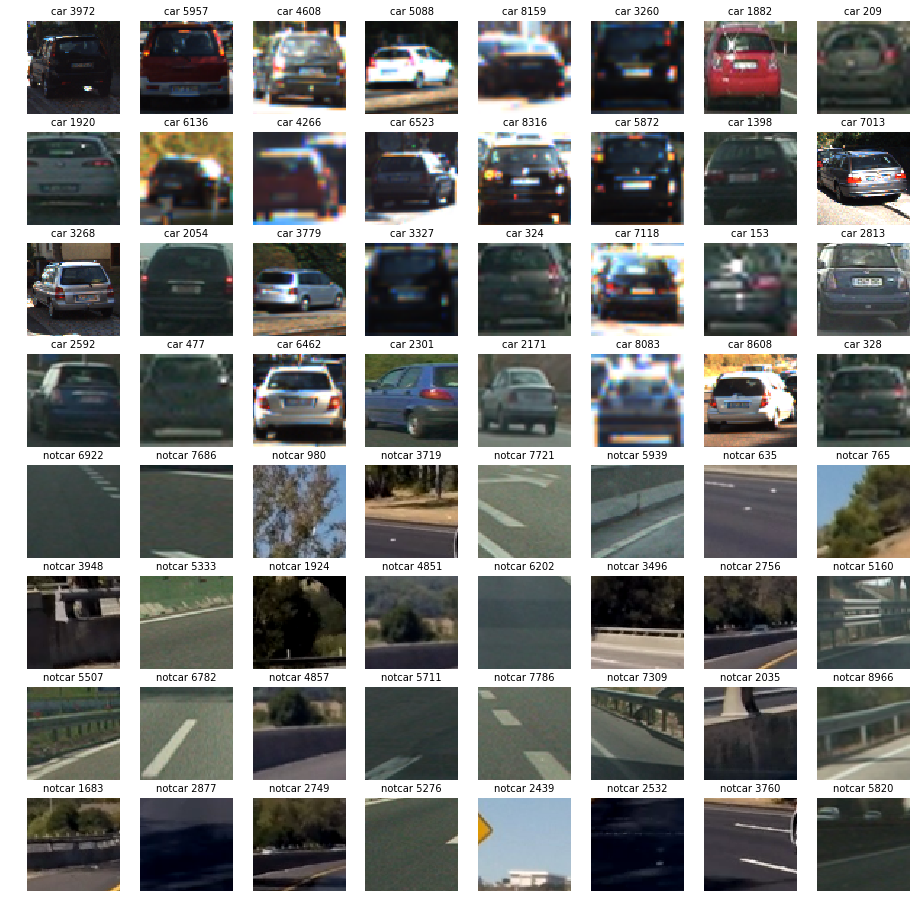

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import os

%matplotlib inline

def get_filename(file_dir):
    file_list = []
    for root, dirs, files in os.walk(file_dir):
        for file in files:
            if file.endswith('.png'):
                file_list.append(os.path.join(root, file))
    return file_list

cars_dir = './vehicles/vehicles'
notcars_dir = './non-vehicles/non-vehicles'

cars = get_filename(cars_dir)
notcars = get_filename(notcars_dir)

# Define a function to return some characteristics of the dataset 
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    example_img = mpimg.imread(car_list[0])
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = example_img.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = example_img.dtype
    # Return data_dict
    return data_dict
    
data_info = data_look(cars, notcars)

print('A count of', data_info["n_cars"], ' cars and', data_info["n_notcars"], ' non-cars',
    'of size: ',data_info["image_shape"], ' and data type:', data_info["data_type"])

fig, axs = plt.subplots(8,8, figsize=(16, 16))
fig.subplots_adjust(hspace =.2, wspace=.1)
axs = axs.ravel()

# Step through the list and search for chessboard corners
for i in range(64):
    if i > 31:
        num = np.random.randint(0, len(notcars))
        image_file = notcars[num]
        title = 'notcar {}'.format(num)
    else:
        num = np.random.randint(0, len(cars))
        image_file = cars[num]
        title = 'car {}'.format(num)
    image = mpimg.imread(image_file)
    axs[i].set_title(title, fontsize=10)
    axs[i].axis('off')
    axs[i].imshow(image)


##### HOG FEATURE VISUALIZATION

D:\ProgramData\Anaconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


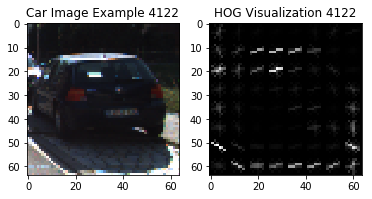

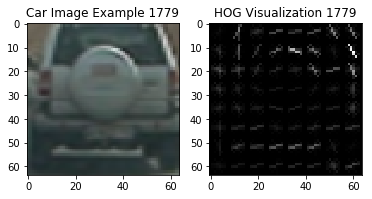

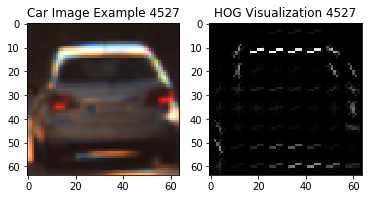

In [2]:
import cv2
from skimage.feature import hog

# cars, notcars are ready in the previous cell
        
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True: feature_vec = False
    return hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                   cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                   visualise=vis, feature_vector=feature_vec)

for n in range(3):
    # Generate a random index to look at a car image
    ind = np.random.randint(0, len(cars))
    # Read in the image
    image = mpimg.imread(cars[ind])
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # Define HOG parameters
    orient = 9
    pix_per_cell = 8
    cell_per_block = 2
    # Call our function with vis=True to see an image output
    features, hog_image = get_hog_features(gray, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=False)
    # Plot the examples
    fig = plt.figure()
    plt.subplot(121)
    plt.imshow(image, cmap='gray')
    plt.title('Car Image Example {}'.format(ind))
    plt.subplot(122)
    plt.imshow(hog_image, cmap='gray')
    plt.title('HOG Visualization {}'. format(ind))

##### FEATURE EXTRACTION FROM DATA SET

Several feature extraction functions are defined. Here, three features are explored which are
- Raw pixel intensity captures color and shape.
- Histogram of pixel intensity captures color characteristics only.
- Gradients of pixel intensity captures shape only.

Vertical image flipping can be used to augment the data set but I concluded the data set without image flipping are enough.
Finally, the MyClf class was defined which is a classifier class for the problem at hand.

In [3]:
import time
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
# NOTE: the next import is only valid for scikit-learn version <= 0.17
# if you are using scikit-learn >= 0.18 then use this:
#from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split

# Define a function to compute binned color features  

def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

def convert_color(img, color_space = 'RGB'):
    if color_space != 'RGB':
        if color_space == 'HSV':
            return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else:
        return np.copy(img)
            

# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    feature_image = convert_color(img, color_space)
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True))
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)
    #9) Return concatenated array of features
    return np.concatenate(img_features)

def get_vector(cars, notcars, spatial_size, hist_bins, color_space, orient, pix_per_cell, cell_per_block, hog_channel,
              spatial_feat=True, hist_feat=True, hog_feat=True, vis =True, normalization = True):
    t = time.time()
    car_features = []
    for car in cars:
        img = mpimg.imread(car)
        car_features.append(single_img_features(img, color_space=color_space, spatial_size = spatial_size,
                                hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                                hog_channel=hog_channel, spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat))
#        img = cv2.flip(img, 1)
#        car_features.append(single_img_features(img, color_space=color_space, spatial_size = spatial_size,
#                                hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
#                                hog_channel=hog_channel, spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat))
    notcar_features = []
    for notcar in notcars:
        img = mpimg.imread(notcar)
        notcar_features.append(single_img_features(img, color_space=color_space, spatial_size = spatial_size,
                               hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                               hog_channel=hog_channel, spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat))
#        img = cv2.flip(img, 1)
#        notcar_features.append(single_img_features(img, color_space=color_space, spatial_size = spatial_size,
#                               hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
#                               hog_channel=hog_channel, spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat))
        
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to extract Cloor and HOG features...')
    print('A count of', len(car_features), ' cars and', len(notcar_features), ' non-cars',
    'of size: ',len(car_features[0]), ',', len(notcar_features[0]))

    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)
    X_scaler = []
    if normalization:
        # Fit a per-column scaler
        X_scaler = StandardScaler().fit(X)
        # Apply the scaler to X
        scaled_X = X_scaler.transform(X)
    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

    # Plot an example of raw and scaled features
    if vis:
        car_ind = np.random.randint(0, len(cars))
        fig = plt.figure(figsize=(12,4))
        plt.subplot(131)
        plt.imshow(mpimg.imread(cars[car_ind]))
        plt.title('Original Image')
        plt.subplot(132)
        plt.plot(X[car_ind])
        plt.title('Raw Features')
        plt.subplot(133)
        if normalization:
            plt.plot(scaled_X[car_ind])
        plt.title('Normalized Features')
        fig.tight_layout()

    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    if normalization:
        X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)
    else:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_state)
    print('Using spatial binning of:',spatial_size, 'and', hist_bins,'histogram bins')
    print('Using:',orient,'orientations',pix_per_cell, 'pixels per cell and', cell_per_block,'cells per block')
    print('Feature vector length:', len(X_train[0]))
    return X_train, X_test, y_train, y_test, X_scaler

class MyClf:
    def __init__(self, cars, notcars, params, best_params_ = {'C': 4, 'kernel' : 'rbf'}):
        X_train, X_test, y_train, y_test, X_scaler = get_vector(cars, notcars, **params)
        self.params = params
        # Use a linear SVC 
        self.svc = SVC(**best_params_)
        self.scaler = X_scaler
        # Check the training time for the SVC
        t = time.time()
        self.svc.fit(X_train, y_train)
        t2 = time.time()
        print(round(t2-t, 2), 'Seconds to train SVC...')
        # Check the score of the SVC
        print('Test Accuracy of SVC = ', round(self.svc.score(X_test, y_test), 4))
        # Check the prediction time for a single sample
        t = time.time()
        n_predict = 18
        print('My SVC predicts :', self.svc.predict(X_test[0:n_predict]))
        print('For these labels:', y_test[0:n_predict])
        t2 = time.time()
        print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')


D:\ProgramData\Anaconda3\envs\carnd-term1\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


##### FEATURE PARAMETER TUNING
3 types of features have the following parameters.

| Parameter     | Explanation | Examples |
|:-------------:|:-------------:|:-------------:|
| spatial_size | Spatial binning dimensions| (32,32) or (16,16) |
| hist_bins    | Number of histogram bins | 16, 32, 40, ...|
| color_space  | Color Space Conversion | 'RGB', 'HSV', 'LUV', 'HLS', 'YUV', 'YCrCb' |
| orient       | HOG orientation resolution | 9, 11, 13, ... |
| pix_per_cell | HOG Pixels per cell | 8, 12, ...|
| cell_per_block | HOG cells per block | 2, 3, ...|
| hog_channel  | channel to be applied in HOG | 0, 1, 2, or 'ALL' |

The following parameter set was chosen by extensive time-consuming explorations.

| Parameter    | Value |
|:------------:|:-------------:|
| spatial_size | (16,16) |
| color_space  | 'YUV' |
| orient       | 11 |
| pix_per_cell | 16 |
| cell_per_block | 2 |
| hog_channel  | 'ALL' |

The color channel histogram feature is not used after evaluating the final outcome. So `hist_bins` parameter is undefined. The concatenated feature data is normalized by calling `StandardScaler` from `sklearn.preprocessing` library and shuffled to be ready a classifier training.


D:\ProgramData\Anaconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


51.34 Seconds to extract Cloor and HOG features...
A count of 8792  cars and 8968  non-cars of size:  1956 , 1956
Using spatial binning of: (16, 16) and 16 histogram bins
Using: 11 orientations 16 pixels per cell and 2 cells per block
Feature vector length: 1956
54.97 Seconds to train SVC...
Test Accuracy of SVC =  0.9961
My SVC predicts : [ 1.  0.  0.  0.  0.  1.  0.  1.  1.  1.  1.  0.  1.  0.  1.  1.  0.  0.]
For these labels: [ 1.  0.  0.  0.  0.  1.  0.  1.  1.  1.  1.  0.  1.  0.  1.  1.  0.  0.]
0.0625 Seconds to predict 18 labels with SVC


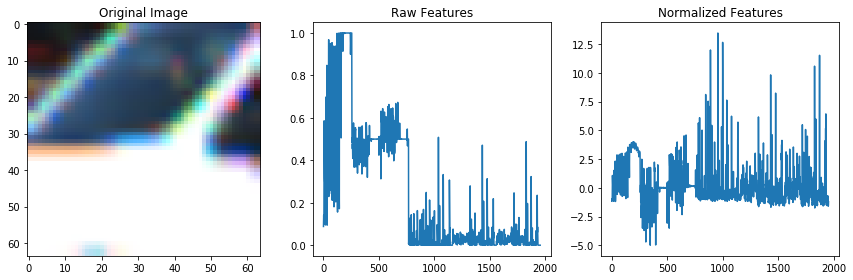

In [4]:

### Tweak these parameters and see how the results change.

params = {'spatial_size' : (32, 32), # Spatial binning dimensions
          'hist_bins' : 32,    # Number of histogram bins
          'color_space' : 'YCrCb', # Can be RGB, HSV, LUV, HLS, YUV, YCrCb, 
          'orient' : 9,  # HOG orientations
          'pix_per_cell' : 8, # HOG pixels per cell
          'cell_per_block' : 2, # HOG cells per block
          'hog_channel' : 'ALL', # Can be 0, 1, 2, or "ALL"
          'spatial_feat' : True, 
          'hist_feat' : True, 
          'hog_feat' : True,
          'vis' : True,
          'normalization' : True} # visualization or not


params = {'spatial_size' : (16, 16), # Spatial binning dimensions
          'hist_bins' : 16,    # Number of histogram bins
          'color_space' : 'YUV', # Can be RGB, HSV, LUV, HLS, YUV, YCrCb, 
          'orient' : 11,  # HOG orientations
          'pix_per_cell' : 16, # HOG pixels per cell
          'cell_per_block' : 2, # HOG cells per block
          'hog_channel' : 'ALL', # Can be 0, 1, 2, or "ALL"
          'spatial_feat' : True, 
          'hist_feat' : False, 
          'hog_feat' : True,
          'vis' : True,
          'normalization' : True} # visualization or not


myclf = MyClf(cars, notcars, params)       

#### CRITERIA
- Describe how (and identify where in your code) you trained a classifier using your selected HOG features (and color features if you used them).

A classifier parameter tuning was done by `GridSearchCV` function from `sklearn.model_selection' library. The final parameters are the following.

| Parameter    | Value | Meaning |
|:------------:|:-------------:|:---:|
| kernel | (16,16) |Specifies the kernel type to be used in the algorithm.|
|  C | 4 | Penalty parameter C of the error term. |

D:\ProgramData\Anaconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


51.19 Seconds to extract Cloor and HOG features...
A count of 8792  cars and 8968  non-cars of size:  1956 , 1956
Using spatial binning of: (16, 16) and 16 histogram bins
Using: 11 orientations 16 pixels per cell and 2 cells per block
Feature vector length: 1956
{'C': 4, 'kernel': 'rbf'}


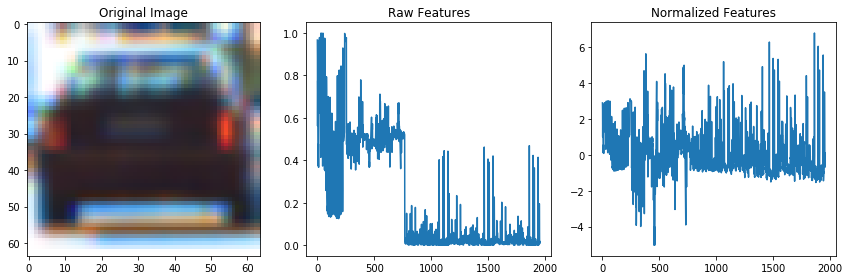

In [5]:
# Classifier Parameter Tuning
from sklearn import svm
from sklearn.model_selection import GridSearchCV
if False:
    parameters = {'kernel':('linear', 'rbf'), 'C':[0.8, 1, 2, 4, 8]}
    X_train, X_test, y_train, y_test, X_scaler = get_vector(cars, notcars, **params)
    svr = svm.SVC()
    clf = GridSearchCV(svr, parameters)
    clf.fit(X_train, y_train)
    print(clf.best_params_)

## 3. Sliding Windows Search

#### CRITERIA
- Describe how (and identify where in your code) you implemented a sliding window search. How did you decide what scales to search and how much to overlap windows?

As was described in the course 'Tips and Tricks for the Project', I extract HOG features just once for the entire region of interest in each full image / video frame and subsample that array for each sliding window. Actually, the function `find_cars` in the course does this job. So I began to modify this function to incorporate some features such as `spatial_size`, `hist_bins`, and normalization on/off.
When it comes to scales to search, I examined the test images and video to estimate the car size and position in images and tested several times to embrace the following values.


| scan number | ystart | ystop | scale |
|-------------|--------|-------|-------|
| 0           | 416    | 480   |  1.0  |
| 1           | 400    | 496   |  1.2  |
| 2           | 400    | 496   |  1.5  |
| 3           | 400    | 528   |  2.0  |
| 4           | 464    | 660   |  2.5  |


D:\ProgramData\Anaconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


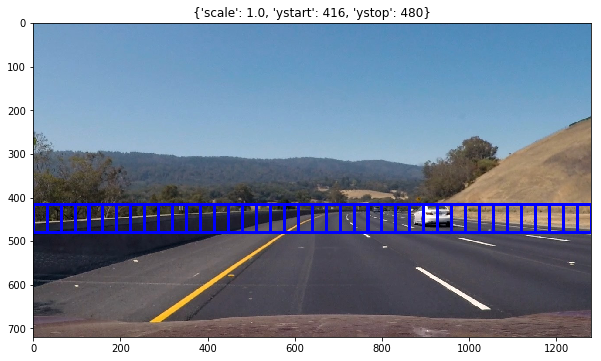

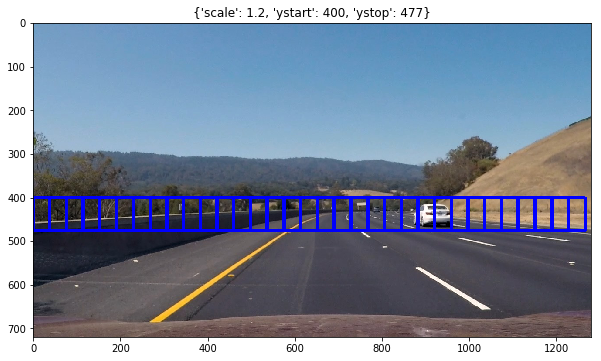

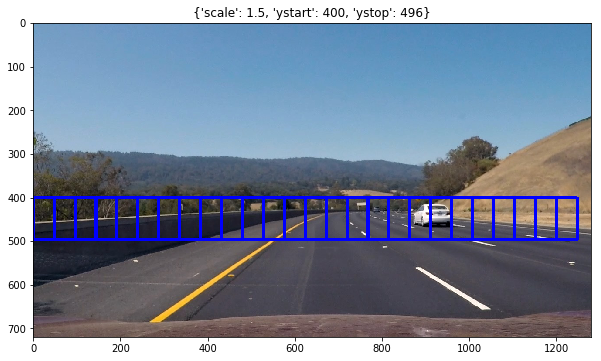

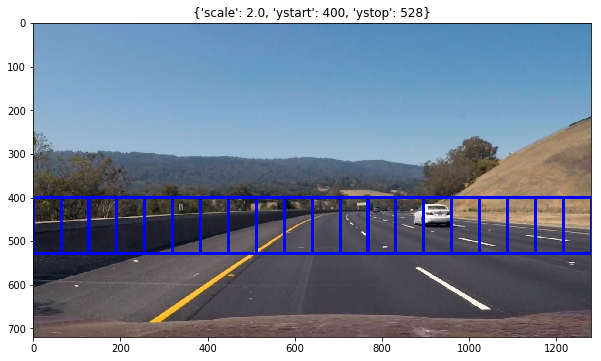

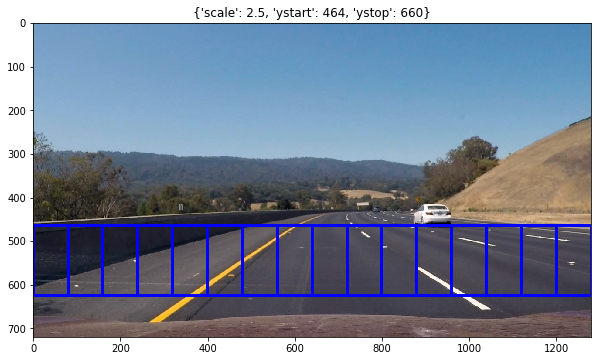

In [6]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, 
             color_space, hog_channel, spatial_feat, hist_feat, hog_feat, vis, normalization):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, color_space)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    if hog_channel == 'ALL':
        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]
    else:
        ch1 = ctrans_tosearch[:,:,hog_channel]
    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    if hog_channel == 'ALL':
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    boxes = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            if hog_channel == 'ALL':
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            else:
                hog_features = hog_feat1

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            if spatial_feat or hist_feat:
                subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size) if spatial_feat else []
            hist_features = color_hist(subimg, nbins=hist_bins) if hist_feat else []

            # Scale features and make a prediction
            if normalization:
                test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))
            else:
                test_features = np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1)
            test_prediction = svc.predict(test_features)
            # array of boxes where cars were detected
            
            if test_prediction == 1 or vis:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                pt0 = (xbox_left, ytop_draw+ystart)
                pt1 = (xbox_left+win_draw,ytop_draw+win_draw+ystart)
                boxes.append((pt0,pt1))
                cv2.rectangle(draw_img, pt0, pt1, (0,0,255), 6)
    return boxes, draw_img


img = mpimg.imread('./test_images/test3.jpg')

scan_params = [
#            {'ystart' : 400, 'ystop' : 464, 'scale' : 0.5},
#            {'ystart' : 416, 'ystop' : 480, 'scale' : 0.5},
#            {'ystart' : 400, 'ystop' : 464, 'scale' : 1.0},
            {'ystart' : 416, 'ystop' : 480, 'scale' : 1.0},
            {'ystart' : 400, 'ystop' : 477, 'scale' : 1.2},
#            {'ystart' : 416, 'ystop' : 493, 'scale' : 1.2},    
#            {'ystart' : 400, 'ystop' : 484, 'scale' : 1.3},
#            {'ystart' : 416, 'ystop' : 500, 'scale' : 1.3},    
            {'ystart' : 400, 'ystop' : 496, 'scale' : 1.5},
#            {'ystart' : 432, 'ystop' : 528, 'scale' : 1.5},
            {'ystart' : 400, 'ystop' : 528, 'scale' : 2.0},
#            {'ystart' : 432, 'ystop' : 560, 'scale' : 2.0},
#            {'ystart' : 400, 'ystop' : 596, 'scale' : 2.5},
            {'ystart' : 464, 'ystop' : 660, 'scale' : 2.5},
        ]

params['vis'] = True

for scan_param in scan_params:
    plt.figure(figsize=(10,10))
    plt.title(scan_param)
    boxes, out_img = find_cars(img = img, svc = myclf.svc, X_scaler = myclf.scaler, **scan_param, **params)
    plt.imshow(out_img)



#### CRITERIA
- Show some examples of test images to demonstrate how your pipeline is working. How did you optimize the performance of your classifier?

I defined the class `Detector` to encapsulate all the pipeline functions. The class usage is shown below.
```python
mydetector = Detecter(1, 2, clf = my_clf, scan_params = params)
image = mpimg.imread(image_p)
detected_image= mydetector.video_proc(image)
```
The car-detecting image applied to this pipeline are shown  with the heatmap image below.

['test_images\\test1.jpg', 'test_images\\test2.jpg', 'test_images\\test3.jpg', 'test_images\\test4.jpg', 'test_images\\test5.jpg', 'test_images\\test6.jpg']


D:\ProgramData\Anaconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


5.88 Seconds to process test images


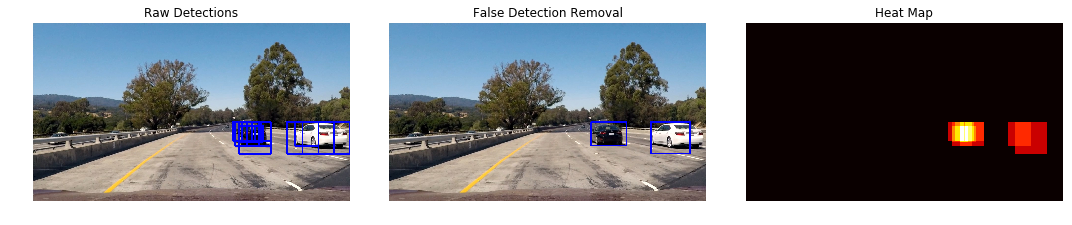

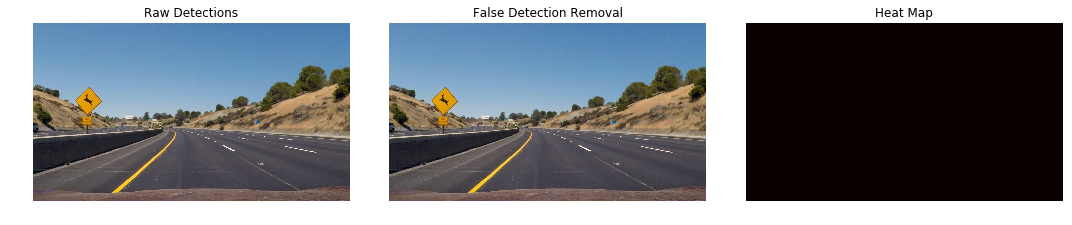

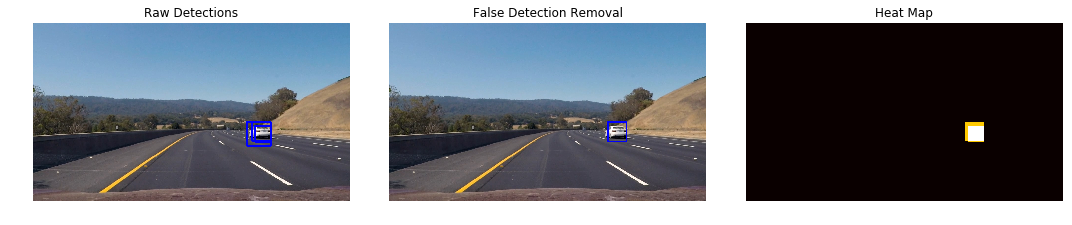

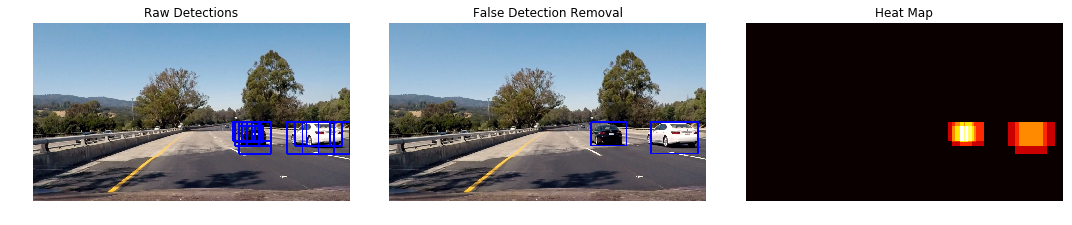

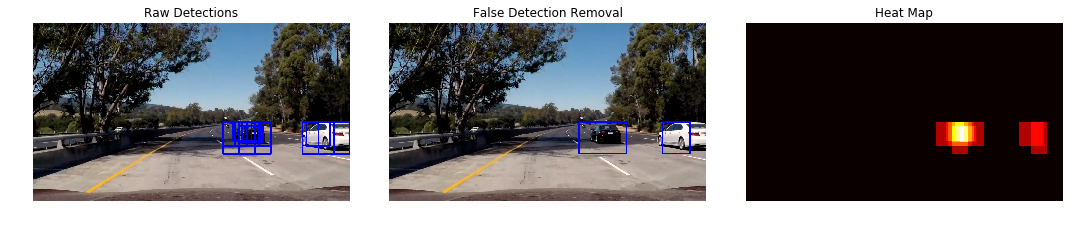

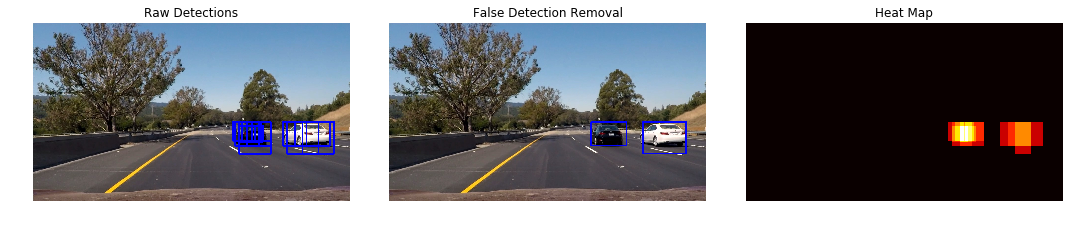

In [7]:
def draw_labeled_bboxes(image, labels):
    img = np.copy(image)
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

from scipy.ndimage.measurements import label

class Detecter:
    def __init__(self, qnum, th, lane_finding, clf, scan_params):
        self.svc = clf.svc
        self.scaler = clf.scaler
        self.params = clf.params
        self.scan_params = scan_params
        self.detected = False
        self.boxbuff = []
        self.heat_init = False
        self.heat = []
        self.number = qnum
        self.threshold = th
        self.lane_on = lane_finding
        if lane_finding:
            self.line = Line('./cal_camera.p')        
        
    def update_heat(self, boxes):
        self.boxbuff.append(boxes)
        if len(self.boxbuff) > self.number:
            self.boxbuff.pop()
        
        for box in boxes:
            # Add += 1 for all pixels inside each bbox
            # Assuming each "box" takes the form ((x1, y1), (x2, y2))
            self.heat[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
            print(self.heat[box[0][1]:box[1][1], box[0][0]:box[1][0]])
            
        if len(self.boxbuff) > self.number:
            for box in self.boxbuff[0]:
                # Add -= 1 for all pixels inside each bbox 
                self.heat[box[0][1]:box[1][1], box[0][0]:box[1][0]] -= 1
            self.boxbuff.pop()

        return np.copy(self.heat)

    def proc(self, image, vis):
        
        boxes = []
        for scan_param in self.scan_params:
            box, window_img = find_cars(img = image, svc = self.svc, X_scaler = self.scaler, **scan_param, **self.params)
            boxes.append(box)
        
        boxes = [item for sublist in boxes for item in sublist]
        self.boxbuff.append(boxes)
        if len(self.boxbuff) > self.number:
            del self.boxbuff[0]
        
        self.heat = np.zeros_like(image[:,:,0]).astype(np.float)
        for boxs in self.boxbuff:
            for box in boxs:
                self.heat[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

        self.heat[self.heat < self.threshold] = 0
        # Find final boxes from heatmap using label function
        labels = label(self.heat)
        draw_img = draw_labeled_bboxes(image, labels)
        if self.lane_on:
            draw_img = self.line.finding(draw_img)
        
        if vis:
            # Visualize the heatmap when displaying    
            heatmap = np.clip(self.heat, 0, 255)            
            window_img = np.copy(image)
            for box in boxes:
                cv2.rectangle(window_img, box[0], box[1], (0,0,255), 6)
            return window_img, draw_img, heatmap
        else:
            return draw_img
    
    def video_proc(self, image):
        return self.proc(image, False)

params['vis'] = False

# Check the prediction time for a single sample
t = time.time()
import glob
#%load_ext autoreload
#%autoreload 2

from lane_finding import Line


print(glob.glob('test_images/test*.jpg'))

for image_p in glob.glob('test_images/test*.jpg'):
    mydet = Detecter(1, 2, False, myclf, scan_params)
    image = mpimg.imread(image_p)
    window_img, draw_img, heatmap = mydet.proc(image, True)

    fig = plt.figure(figsize=(15, 15))
    plt.subplot(131)
    plt.imshow(window_img)
    plt.title('Raw Detections')
    plt.axis('off')
    plt.subplot(132)
    plt.imshow(draw_img)
    plt.title('False Detection Removal')
    plt.axis('off')
    plt.subplot(133)
    plt.imshow(heatmap, cmap='hot')
    plt.title('Heat Map')
    plt.axis('off')
    fig.tight_layout()
 
print(round(time.time()-t, 2), 'Seconds to process test images')

## 4. Video Implementation

#### CRITERIA
- Provide a link to your final video output. Your pipeline should perform reasonably well on the entire project video (somewhat wobbly or unstable bounding boxes are ok as long as you are identifying the vehicles most of the time with minimal false positives.)

I applied the pipeline to the final project video with the help of `moviepy` function. The link to my final video output is shown below.

In [8]:
from moviepy.editor import VideoFileClip

output_file = './writeup_images/project_video_result.mp4'
input_file = './writeup_images/project_video.mp4'

clip = VideoFileClip(input_file)
mydet = Detecter(30, 20, False, myclf, scan_params)
out_clip = clip.fl_image(mydet.video_proc)
out_clip.write_videofile(output_file, audio=False)


[MoviePy] >>>> Building video ./writeup_images/project_video_result.mp4
[MoviePy] Writing video ./writeup_images/project_video_result.mp4


100%|█████████████████████████████████████▉| 1260/1261 [15:32<00:00,  1.36it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./writeup_images/project_video_result.mp4 



In [9]:
from IPython.display import HTML

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_file))

#### CRITERIA
- Describe how (and identify where in your code) you implemented some kind of filter for false positives and some method for combining overlapping bounding boxes.

I accumulated heat map values over the past 30 frames and forced to zero the heat map values less than 20. These are specified in the `Detector` class constructor arguments such as `Detector(qnum = 30, th = 20, ...)`. This kind of averaging filters false positives and enable more robust detection. 
This is done in the function 'prod()' which shows the following code snippet.

This has two impacts.
 1. It provides a robust detection for rejecting outliers.
 2. It reduces jitter for box detection over frames.

```python
    def proc(self, image, vis):        
        # Scan several windows defined in the self.scan_params
        boxes = []
        for scan_param in self.scan_params:
            box, window_img = find_cars(img = image, svc = self.svc, X_scaler = self.scaler, **scan_param, **self.params)
            boxes.append(box)        
        boxes = [item for sublist in boxes for item in sublist]
        
        # Accumulate `self.number` of frame boxes
        self.boxbuff.append(boxes)
        if len(self.boxbuff) > self.number:
            del self.boxbuff[0]
        
        # Construct heat map over the past frames and apply threshold to it
        self.heat = np.zeros_like(image[:,:,0]).astype(np.float)
        for boxs in self.boxbuff:
            for box in boxs:
                self.heat[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
        self.heat[self.heat < self.threshold] = 0
                    
        # ... some codes ....
                    
        return draw_img
```

## 5. Discussion

#### CRITERIA
- Briefly discuss any problems / issues you faced in your implementation of this project. Where will your pipeline likely fail? What could you do to make it more robust?

As an optional challenge, I combined this vehicle detection pipeline with the lane finding implementation from the last project. In order to do that, I made a python module `lane_finding.py` from the previous IPython file. Then I incorporate it to the `Detector` class feature which is enabled by the argument `lane_finding = True`.

In [11]:
output_file = './writeup_images/project_video_result_with_lane.mp4'
input_file = './writeup_images/project_video.mp4'

clip = VideoFileClip(input_file)
mydet = Detecter(30, 20, True, myclf, scan_params)
out_clip = clip.fl_image(mydet.video_proc)
out_clip.write_videofile(output_file, audio=False)

[MoviePy] >>>> Building video ./writeup_images/project_video_result_with_lane.mp4
[MoviePy] Writing video ./writeup_images/project_video_result_with_lane.mp4


100%|█████████████████████████████████████▉| 1260/1261 [20:04<00:00,  1.04it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./writeup_images/project_video_result_with_lane.mp4 



In [12]:
from IPython.display import HTML

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_file))